[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/MOOC_Notebooks/Notebook08_UNets.ipynb)

# Notebook 08: U-Networks 

Authors: Randy J. Chase, David R. Harrison, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks and Deep Learning](https://arxiv.org/abs/2211.00147)<br>
Original Github: [WAF_ML_Tutorial_Part2](https://github.com/ai2es/WAF_ML_Tutorial_Part2)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Lackmann, G. M., & McGovern, A. (2023). A Machine Learning Tutorial for Operational Meteorology. Part II: Neural Networks and Deep Learning, 	arXiv:2211.00147.

### Primary Goal:

Build and train a "U"-Network 

#### Background

As an added step of complexity, the next version of neural networks covered in the paper are called "U"-networks. U-Nets are still convolutional neural networks, but now they have a 'down' and an 'up' branch which gives the network architecture the titular "U" shape. The down (or encoding) branch of the network is used to convolve and maxpool the input data, reducing the image size. Then on the 'up' (or decoding) branch, the image is upsampled back to a higher resolution (typically matching the input's original resolution). Figure 6 of the paper is reproduced here for additional context. 

<img src="../images/Fig6_WAF2.png" width="800" height="200" class="center" />

So what does a U-Net do that a CNN can't? 
 
- The main strength of U-Nets is 'image-to-image' translation. In other words the U-Net takes in some input image and then outputs an image with the same shape as the input. For our example, we can use a U-Net to not only predict if there is lightning in the image, but also where in the image it is located. 


#### Step 0: Installs and grab the data 

Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient

In [ ]:
#@title Install and unpack files [this will take some time]

print('installing dependancies')
!pip -q install zenodo-get
!pip -q install zarr 
!pip -q install git+https://github.com/dopplerchase/keras-unet-collection.git
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')

#### Step 1: Imports

As with all of our notebooks, we will first import the necessary packages. 

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#### Step 2: An new package

There is a considerable amount of effort required to code a new U-Net from scratch. It can be done, but programming the upsampling/maxpooling layers while keeping the layer shapes compatible can be tedious. Fortunately, the Github user ```yingkaisha``` has made a useful package that will help construct all sorts of U-Nets. As part of this tutorial, we have made a few adjustments to their package that allow for more customization, and already installed it to this colab session. If you wanted to do it on your own machine run the following command in your terminal (terminal in mac and linux, powershell in windows): 

``` pip install git+https://github.com/dopplerchase/keras-unet-collection.git ``` 

If you don't already have pillow (PIL) you will need to install that too: 

``` install -c conda-forge pillow ``` 

You will need to restart your kernel after installing these packages (click the little replay button on the top taskbar). 

In [2]:
from keras_unet_collection import models

If this import runs without any errors, then you are good to go. The main method we will use here is ```models.unet_2d```. This method will build your U-Net to whatever depth/shape you want it. We will show an example shortly, but first let's load in our dataset.

#### Step 3: Load in the dataset

In [3]:
ds_train = xr.open_dataset('sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir/sub-sevir-val.zarr',engine='zarr')

Next, let's convert the data to tf.data.Datasets again. 

#### Step 4: Make tf.Dataset

This will be very similar to the process used in the previous notebook.  The only difference is this time we will use the ```2d``` labels instead of the ```1d``` labels. 

In [4]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 64
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

2022-12-13 13:43:41.393106: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, let's look at an example from the dataset to verify everything worked as expected.

In [5]:
for batch in ds_train:
    break 

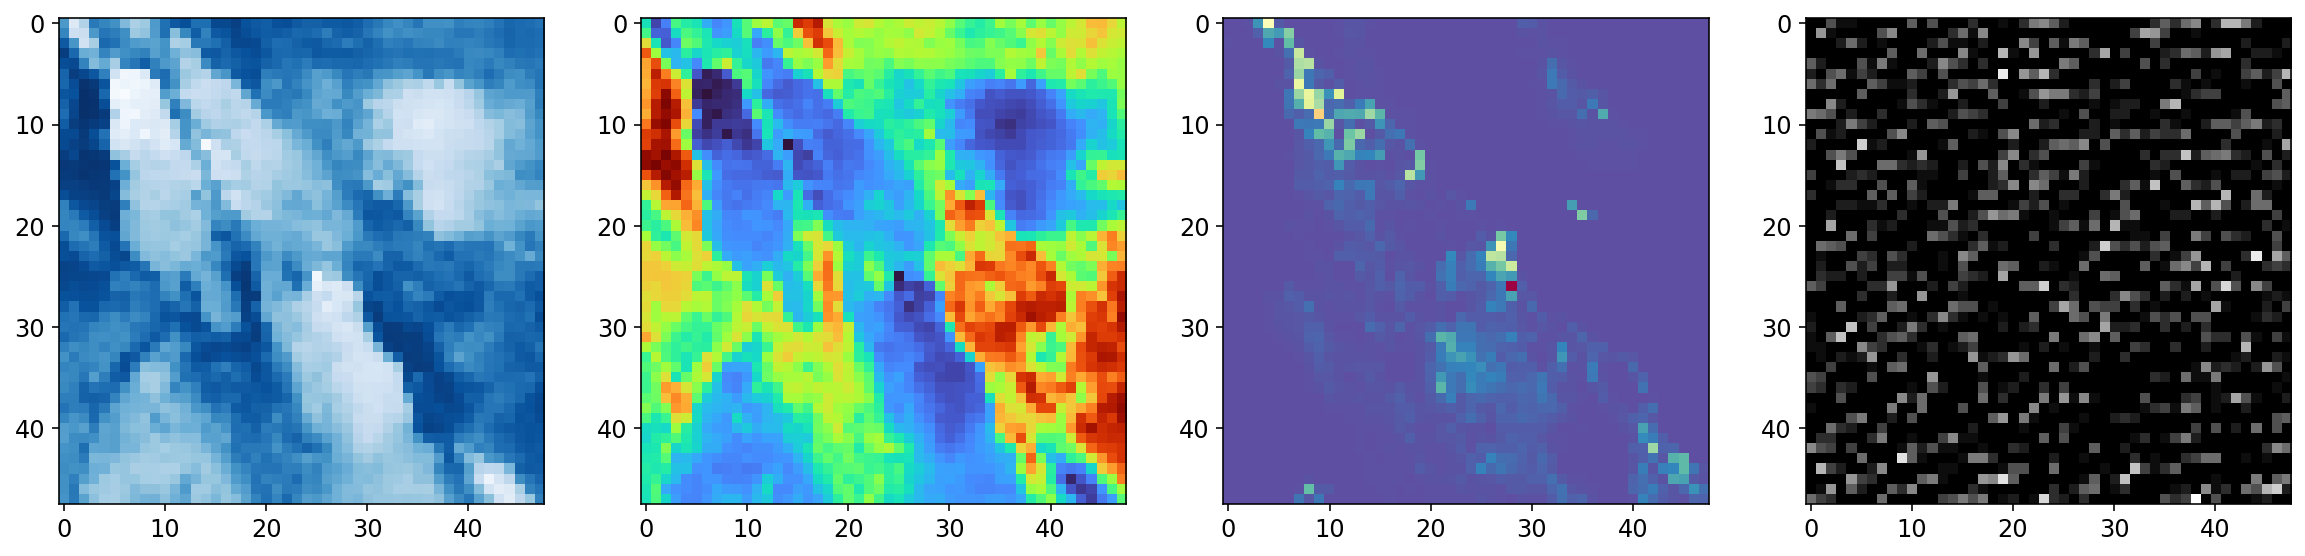

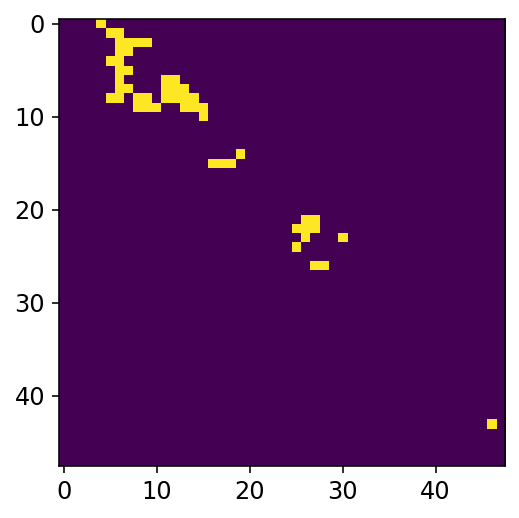

In [6]:
#get the features for example 12 in this batch 
one_example_features = batch[0][29]
#get the label for that same example 
one_example_label = batch[1][29]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

fig,axes = plt.subplots(1,1,figsize=(4,5))
axes.imshow(one_example_label)

The first row of images is still our features (i.e., inputs), which are Water Vapor, Infrared, Radar and Visible. The second row is the label containing a map of the lightning locations. The label is 0 (blue) where there is no lightning and 1 (yellow) where there is lightning. The goal for the U-Net is to produce a map containing the probability of lightning at each pixel. 

#### Step 5: Build the model

This will be different than the previous two notebooks where we used the ```Sequential``` model builder. We will start simple with a U-Net with just 1 maxpool/up-sampling layer. 

The inputs to the model builder are: 

1. input_size
 
    - This is a list of numbers that describe the shape of the input data without the batch dim. Our shape here is ```[48,48,4]```
    
2. filter_num

    - This is a list of the number of filtered maps (convolved images) you want at each layer. For this example we will do 2 maps and then 4. ```[2,4]``` 
    
3. n_labels 

    - An integer representing the number of output maps you want. Here we only have 1 (the map of lightning probability). 
    

These are the only required inputs, but some of the other default inputs will not work for us. We will need to change the:

1. output_activation 
    
    - By default this is ```Softmax``` which is commonly used for multi-class classification tasks. However, our example here only has 1 class, so we need to change this to ```Sigmoid```. 

2. weights

    - By default this is set to ```ImageNet``` which means it will use pre-trained weights from an unrelated machine learning classification task. It might seem strange to use weights from another project, but consider that we as humans use all of our experiences to learn and perform tasks. The idea here is that the weights learned from classifying other datasets may be *transfered* to our example. But for the sake of simplicity, let's set this to None so that the initial weights will be random. 
    
3. stack_num_down/up 

    - This parameter can be used to do multiple convolutions before performing the maxpool/up-sampling. For this example we will just set this to 1. 
    

In [7]:
model = models.unet_2d([48,48,4],[2,4],1,stack_num_down=1,stack_num_up=1,output_activation='Sigmoid',weights=None)

This might make things weird with maxpooling and concatenating the skip connections.
Best to make your data to have power of 2s [e.g., 32, 64, 128, 256, 512]
Your given input shape:  [48, 48, 4]


That warning is okay. It is included as a reminder that unexpected behavior may occur when applying multiple maxpool layers if the shape of your data is not a power of 2. Don't worry about it for now. Just know that the max depth of a U-Net here is 4 down layers (48 -> 24 -> 12 -> 6 -> 3). 

The summary here is a bit more involved than in the other examples you have seen so far, but this is a good demonstration of why you don't want to manually code a U-NET yourself. 

In [8]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 4)]  0           []                               
                                                                                                  
 unet_down0_0 (Conv2D)          (None, 48, 48, 2)    74          ['input_1[0][0]']                
                                                                                                  
 unet_down0_0_activation (ReLU)  (None, 48, 48, 2)   0           ['unet_down0_0[0][0]']           
                                                                                                  
 unet_down1_encode_maxpool (Max  (None, 24, 24, 2)   0           ['unet_down0_0_activation[0][0]']
 Pooling2D)                                                                              

#### Step 6: Run some data through

Okay, let's run some data through the untrained model just to see what a randomly weighted model looks like:

(0.0, 1.0)

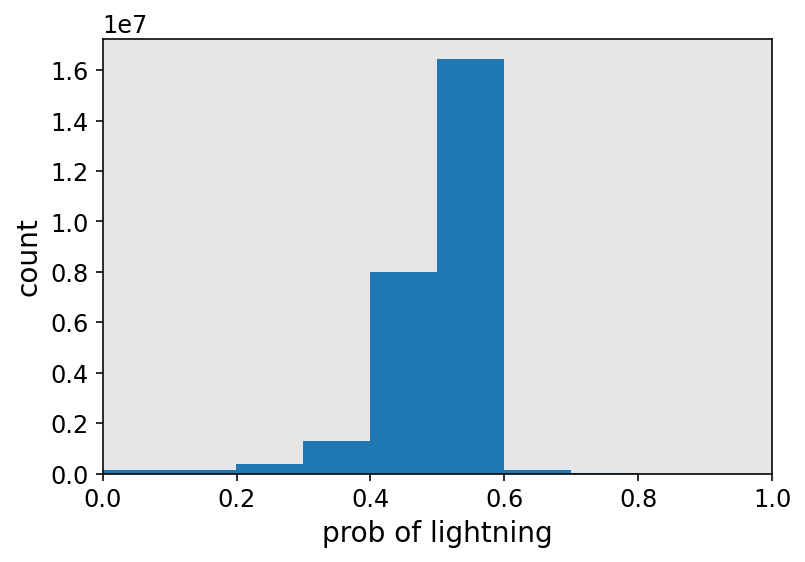

In [9]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

The results are a bit different this time. It looks like most of the predictions are near 0.5, which could be expected for random weights. Let's look at an example: 

In [10]:
#grab a batch to look at 
for batch in ds_val:
    break 

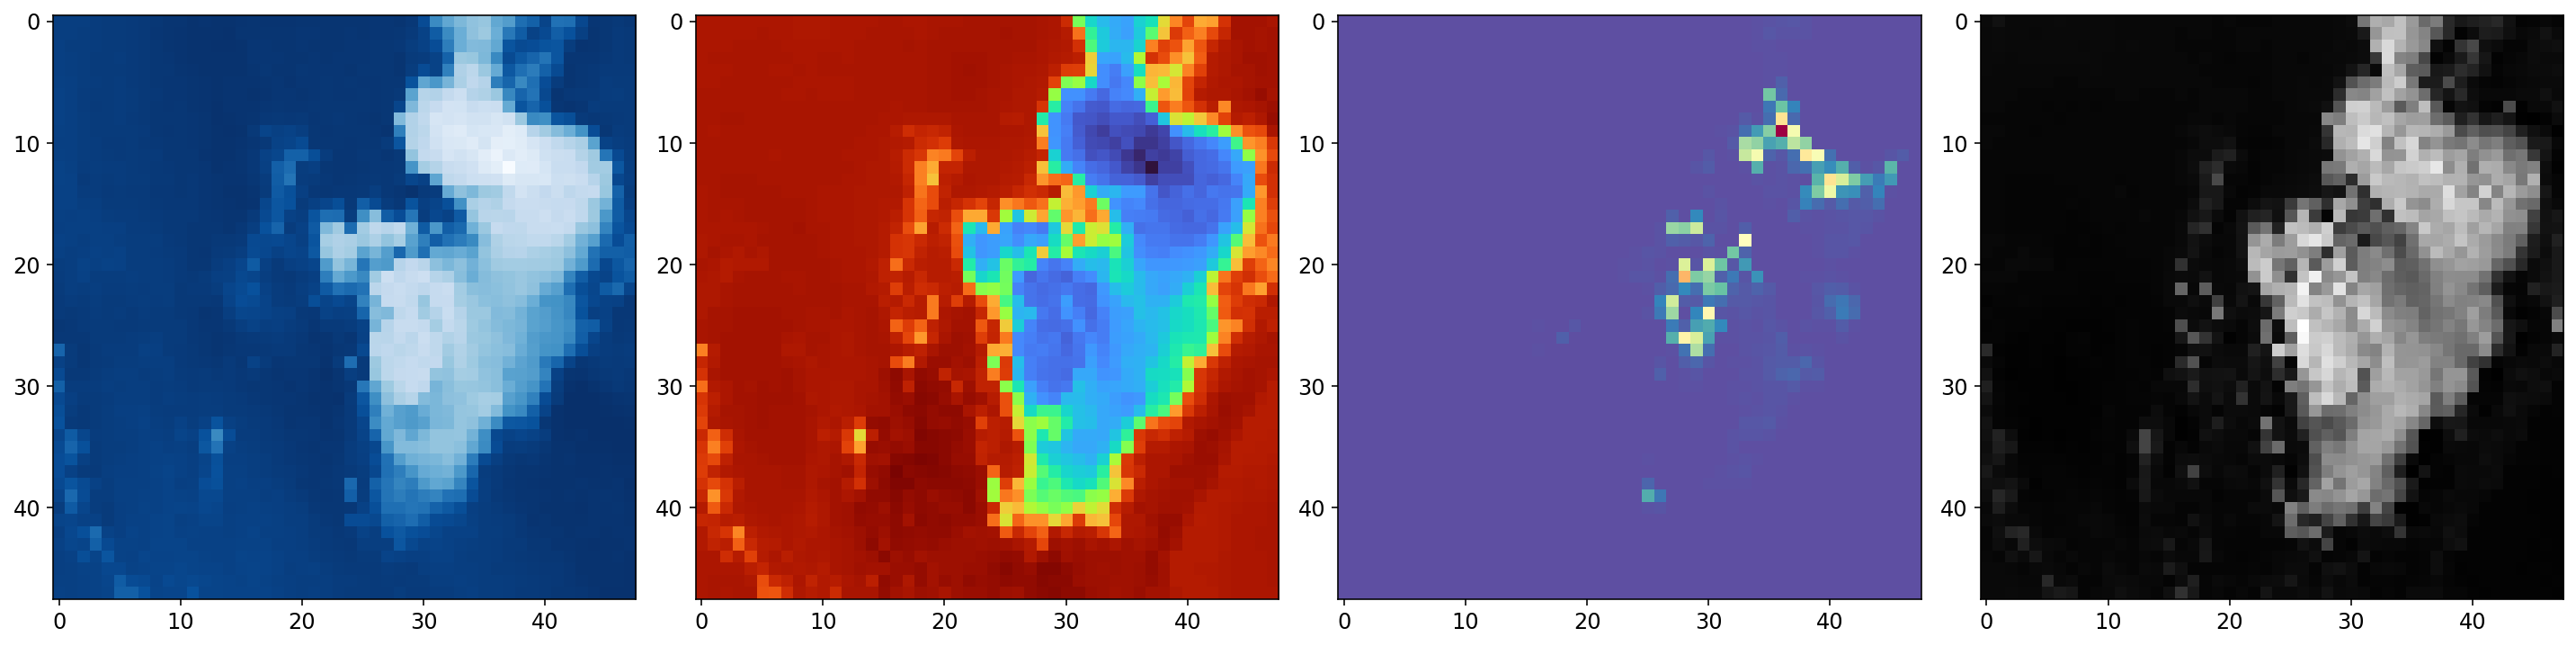

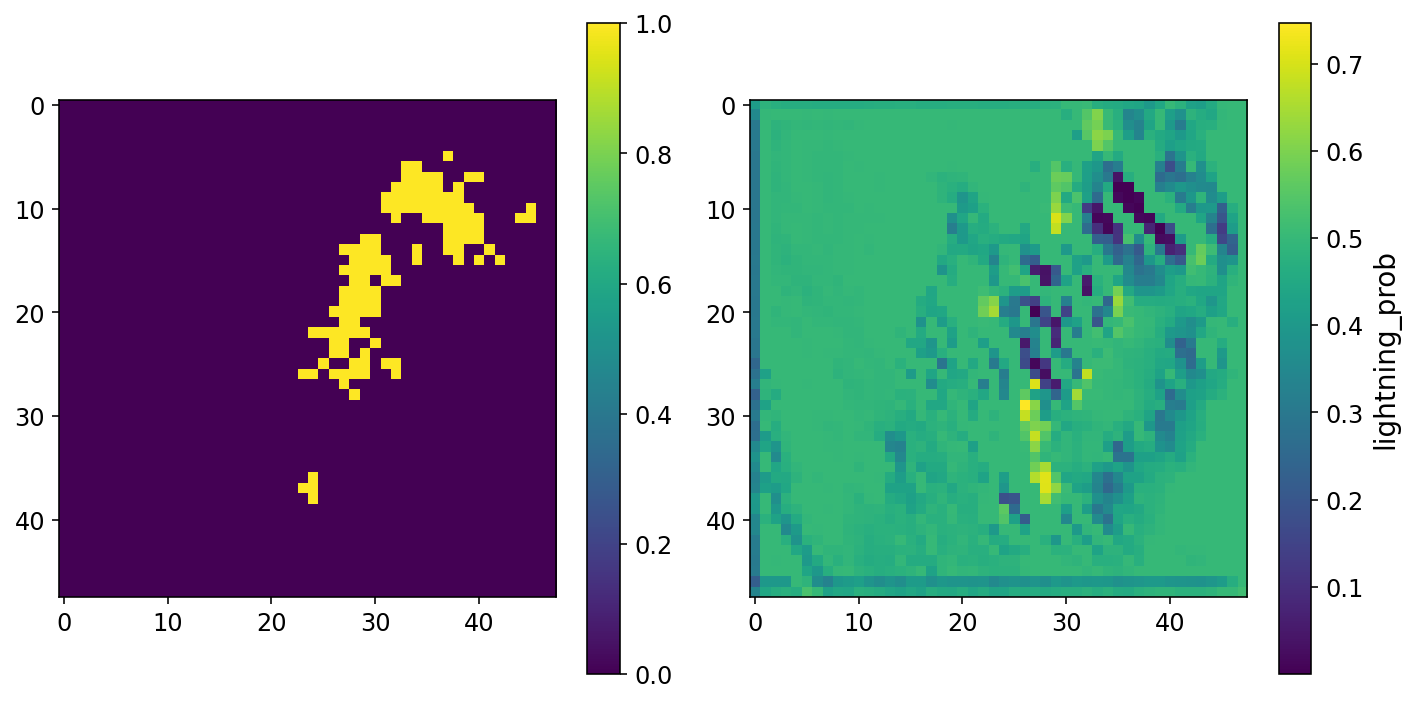

In [11]:
#get the features for example 12 in this batch 
one_example_features = batch[0][27]
#get the label for that same example 
one_example_label = batch[1][27]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5))
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[27])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

As expected, the untrained model appears to be randomly guessing where the lightning is in the image. 

#### Step 7: Compile and train

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=5)

Epoch 1/5
938/938 [==============================] - 60s 63ms/step - loss: 0.3101 - val_loss: 0.1443
Epoch 2/5
938/938 [==============================] - 55s 58ms/step - loss: 0.1251 - val_loss: 0.1187
Epoch 3/5
938/938 [==============================] - 62s 66ms/step - loss: 0.1124 - val_loss: 0.1116
Epoch 4/5
938/938 [==============================] - 55s 59ms/step - loss: 0.0951 - val_loss: 0.0843
Epoch 5/5
938/938 [==============================] - 56s 59ms/step - loss: 0.0784 - val_loss: 0.0795


This may take some time to run depending on your computer. On my particular Macbook Pro, the training takes ~ 1 min per epoch. However, if you are running this on Google Colab, the training should run much faster if you have the GPU enabled. This is where the power of GPUs can be really useful for machine learning. You can run many more training sessions when the code takes ~ 10s per epoch instead of 1 min. 

#### Step 8: Run data through 'trained' model

Like before, let's run some data through our newly trained network



(0.0, 1.0)

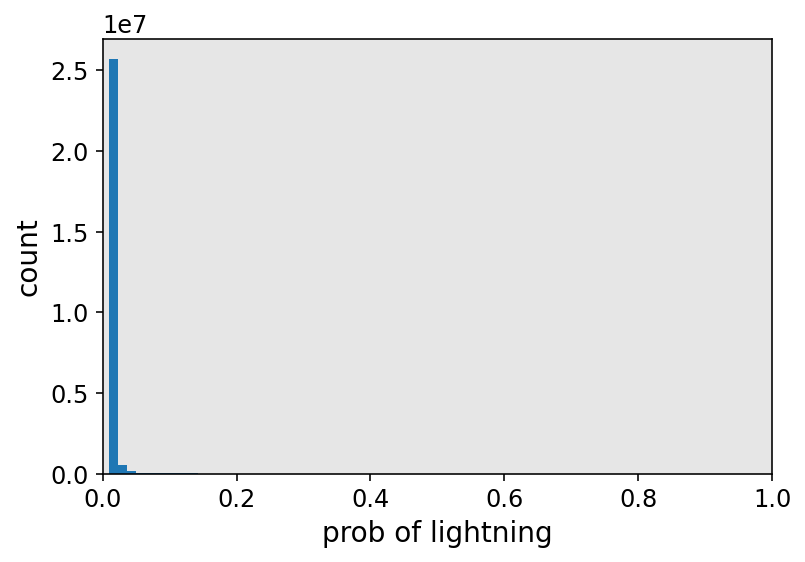

In [13]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

Now most of the output is 0. This is not suprising as lightning is a rare event within the pixels of each image in the dataset.  That is, lightning is typically observed in only a few pixels in each example. Let's see if things make sense spatially by plotting the same example we showed before:

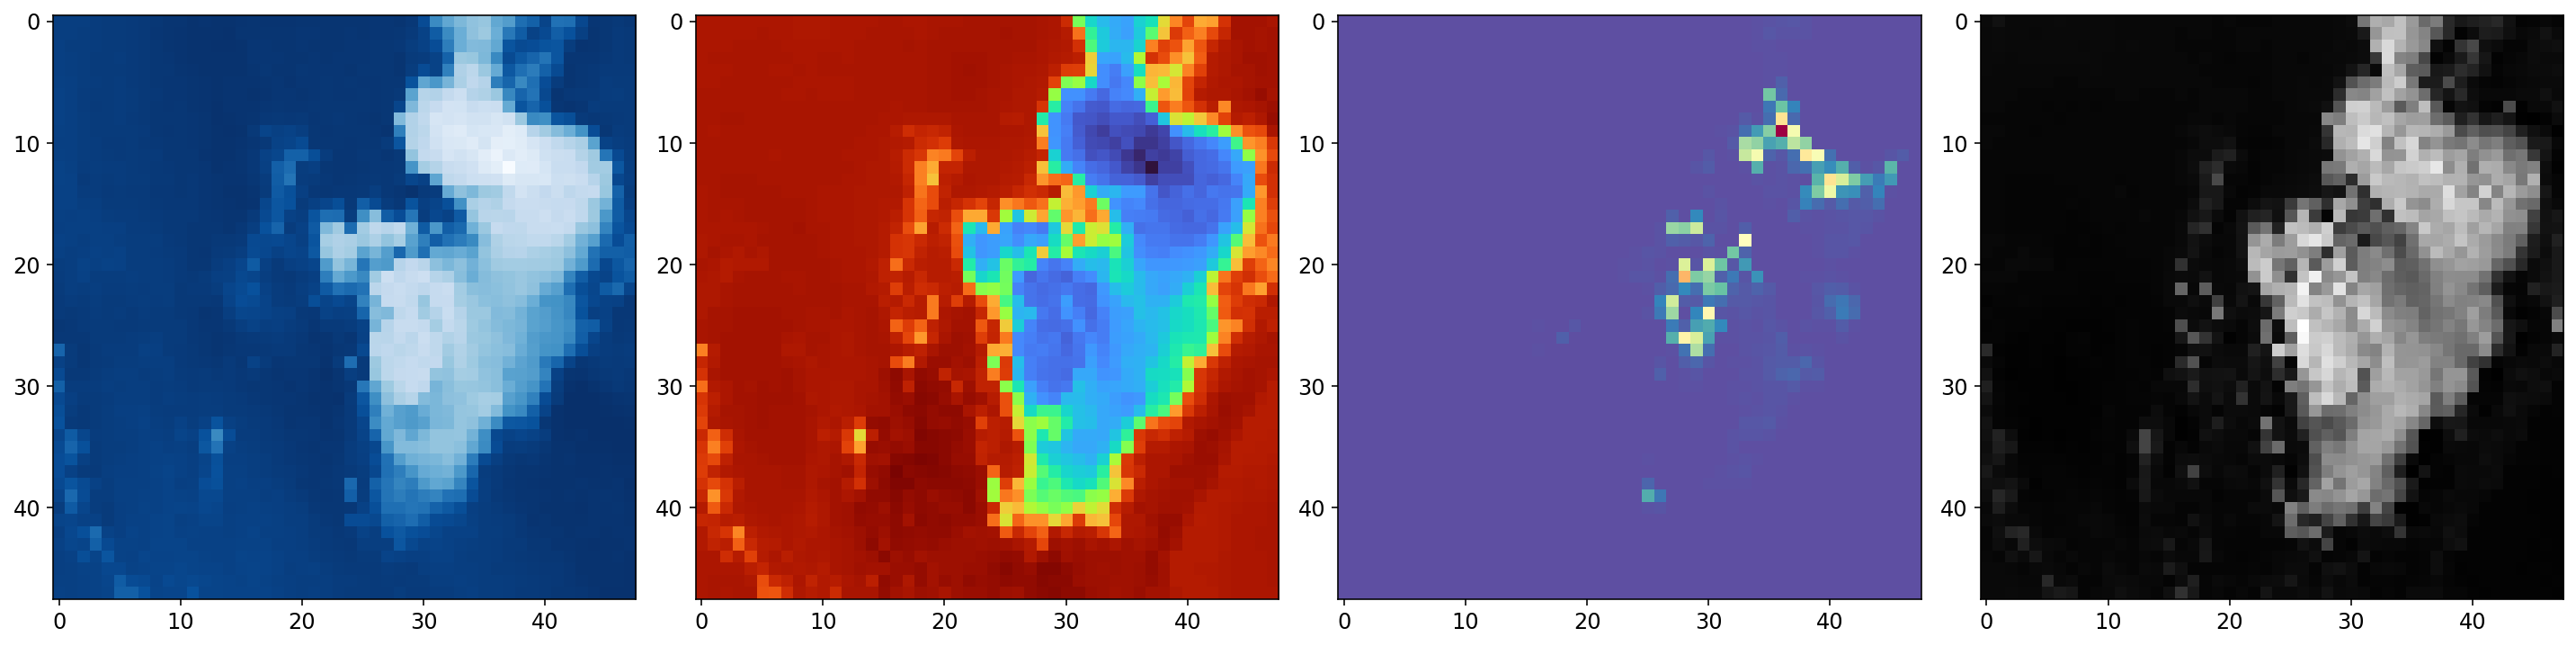

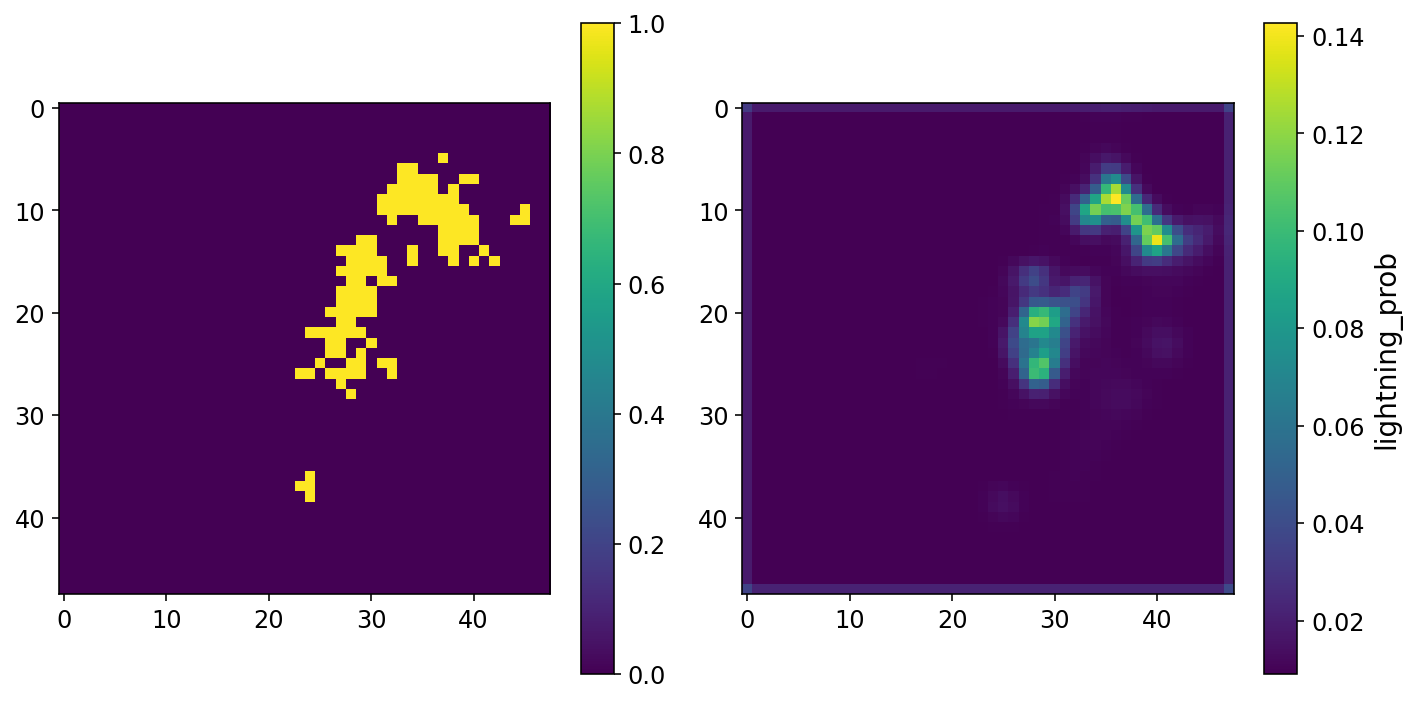

In [14]:
#get the features for example 12 in this batch 
one_example_features = batch[0][27]
#get the label for that same example 
one_example_label = batch[1][27]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[27])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

Good! The model is at least getting the general area of lighting correct. Notice though that the probabilites are quite low (in an absolute sense). Now let's take a look at the performance diagram which should help us better assess this rare event. This will be a pixel-by-pixel analysis, so there are A LOT more samples than  in previous notebooks. 

#### Step 8: Evaluate

First we have to get the truth values for each pixel. We are going to ravel these into a 1-d vector: 

In [15]:
import copy 
for i,(_,y) in enumerate(ds_val):
    if i == 0:
        y_v = copy.deepcopy(y)
    else:
        y_v = np.concatenate([y_v,y])

#ravel both
y_v_rav = y_v.ravel()
y_preds_rav = y_preds.ravel()

In [16]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

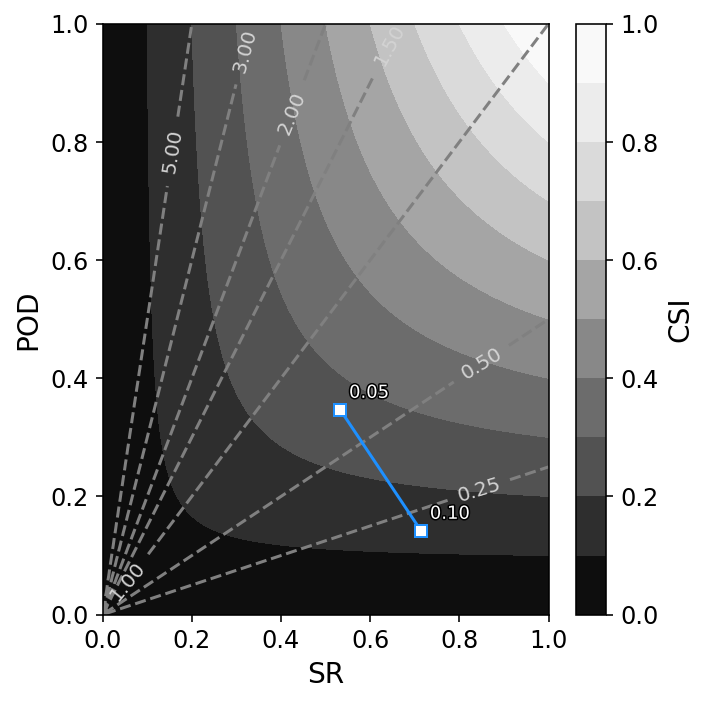

In [17]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

Overall, the performance is not that great. However, we only trained the U-Net for a limited number of epochs, so the network may not have fully converged on a solution. Also remember that this is a much more difficult classification problem than that demonstrated in the other notebooks (i.e., the ANN and CNN ones). We not only want to know if there is lightning in the image, but also *where* that lightning is. Therefore, we may need to calibrate our expectations. 

#### Step 8: Try a slightly different batch_size

You wouldn't be able to tell at this point, but it took us a decent amount of time to find a U-Net that 'works' when trained on a CPU in a reasonable amount of time. To demonstrate the challenge, let's lower the training batch size to 32 instead of 64. 

We need to re-load the datasets and re-batch them as before:

In [18]:
ds_train = xr.open_dataset('sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir/sub-sevir-val.zarr',engine='zarr')

#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_2d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_2d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

In [19]:
model = models.unet_2d([48,48,4],[2,4],1,stack_num_down=1,stack_num_up=1,output_activation='Sigmoid',weights=None)

This might make things weird with maxpooling and concatenating the skip connections.
Best to make your data to have power of 2s [e.g., 32, 64, 128, 256, 512]
Your given input shape:  [48, 48, 4]


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 61s 32ms/step - loss: 0.2188 - val_loss: 0.1188
Epoch 2/5
1875/1875 [==============================] - 62s 33ms/step - loss: 0.1047 - val_loss: 0.0847
Epoch 3/5
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0768 - val_loss: 0.0766
Epoch 4/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0692 - val_loss: 0.0655
Epoch 5/5
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0565 - val_loss: 0.0562


Text(0, 0.5, 'count')

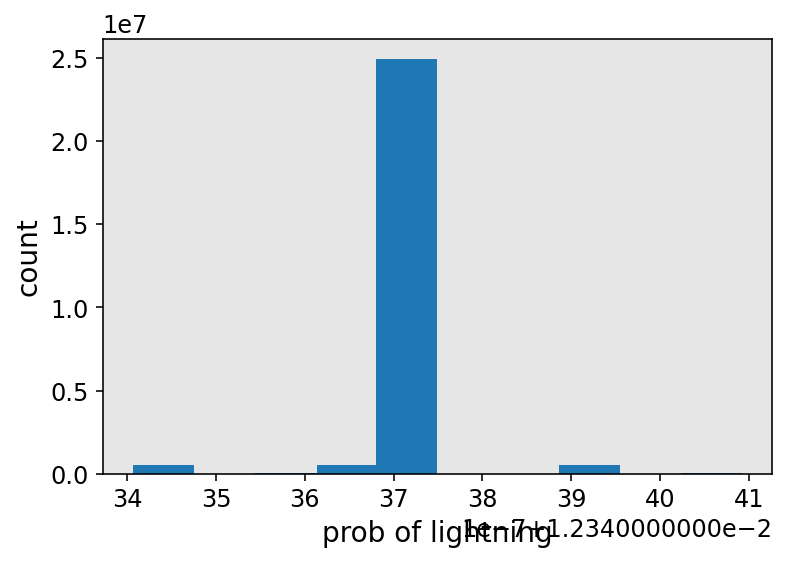

In [21]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
# plt.xlim([0,1])

As you can see here, the lower batch size results in some *oddities*. It looks like the model is predicting one value basically everyhere. But this becomes even more clear when we look at the same example again.

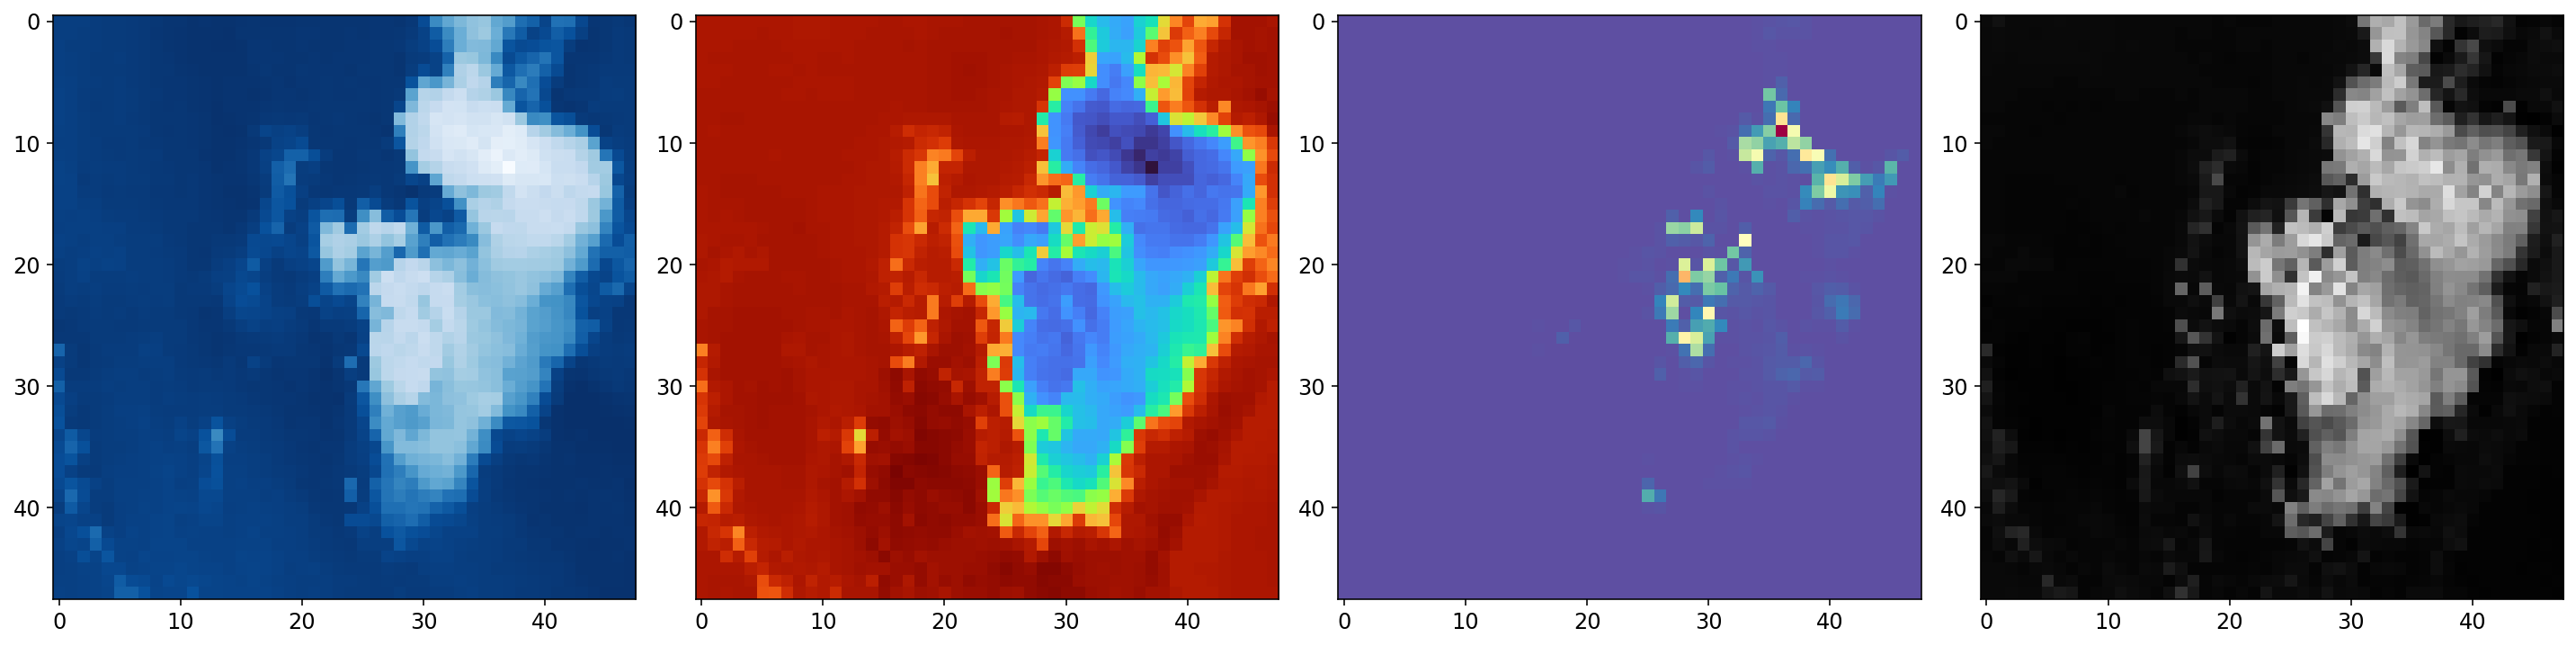

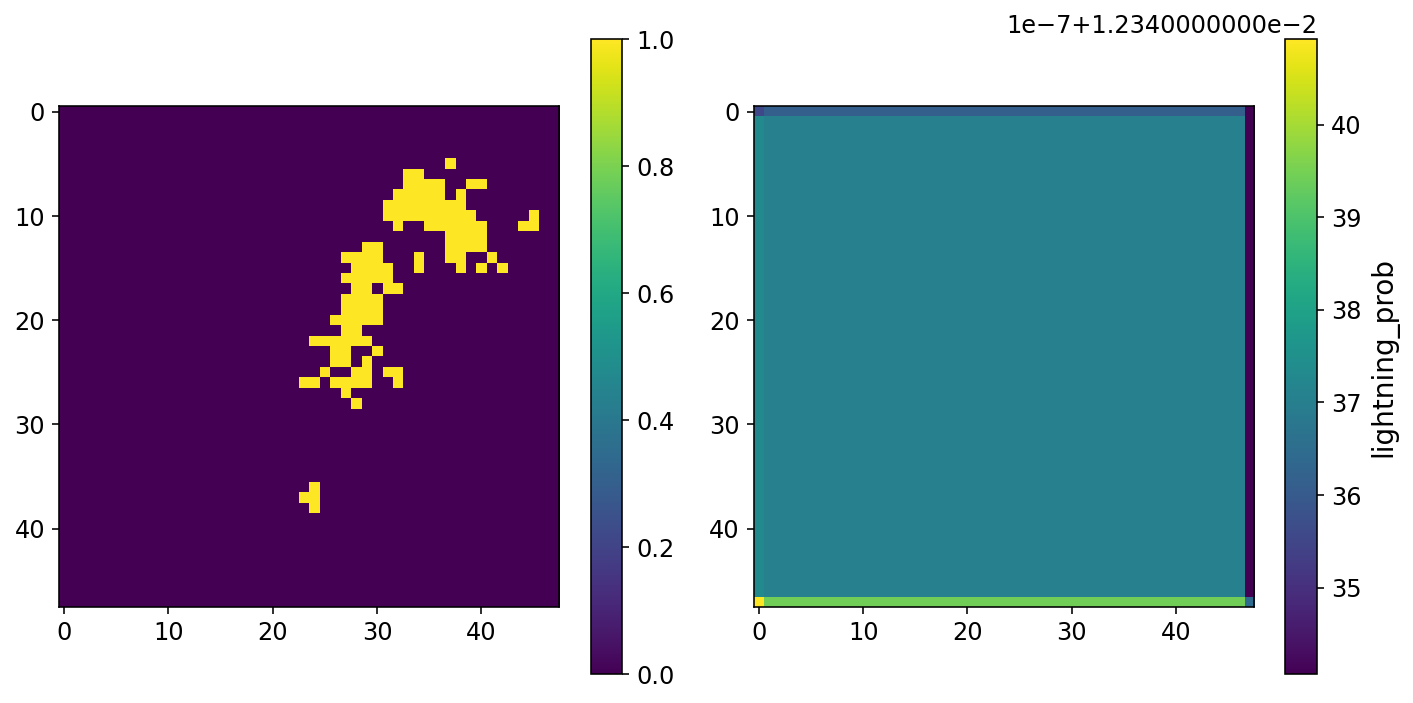

In [22]:
#get the features for example 12 in this batch 
one_example_features = batch[0][27]
#get the label for that same example 
one_example_label = batch[1][27]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[27])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

As we thought, the model is essentially predicting the same value for every pixel in the image. Why does this happen? Perhaps because lightning is a rare event, the model learned to just never predict it while still acheiving decent scores in the context of the loss function. So how does increasing the batch size to 64 help fix this? One theory is that the larger batch size contains more examples of lightning, which then have a greater influence on the loss function. Furthermore, a batch size of 64 will provide a better estimate of the *true* gradient, which should lead to better weights and an improved loss function score. 

This is probably more discussion than necessary for this tutorial, but we wanted to demonstrate that training these ML models is not always as straightforward as it appears. It can be very frustrating at times. 

#### Step 9: Load the U-Net from the paper

Let's get the model from the paper and evaluate it:

In [24]:
model_trained = tf.keras.models.load_model('/content/WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_paper/sub-sevir-unet-class-2d.h5',compile=False)

Text(0, 0.5, 'count')

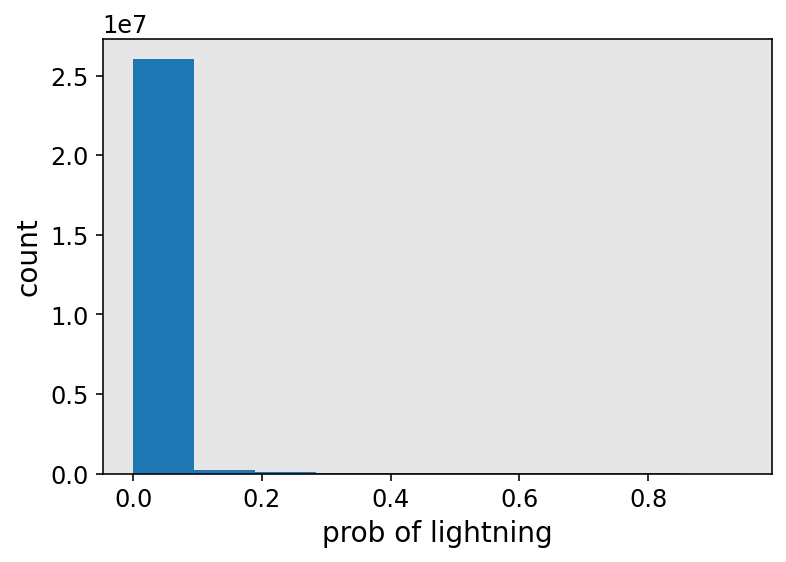

In [25]:
#like sklearn, we do .predict!
y_preds = model_trained.predict(ds_val)

plt.hist(y_preds.ravel())
plt.xlabel('prob of lightning')
plt.ylabel('count')
# plt.xlim([0,1])

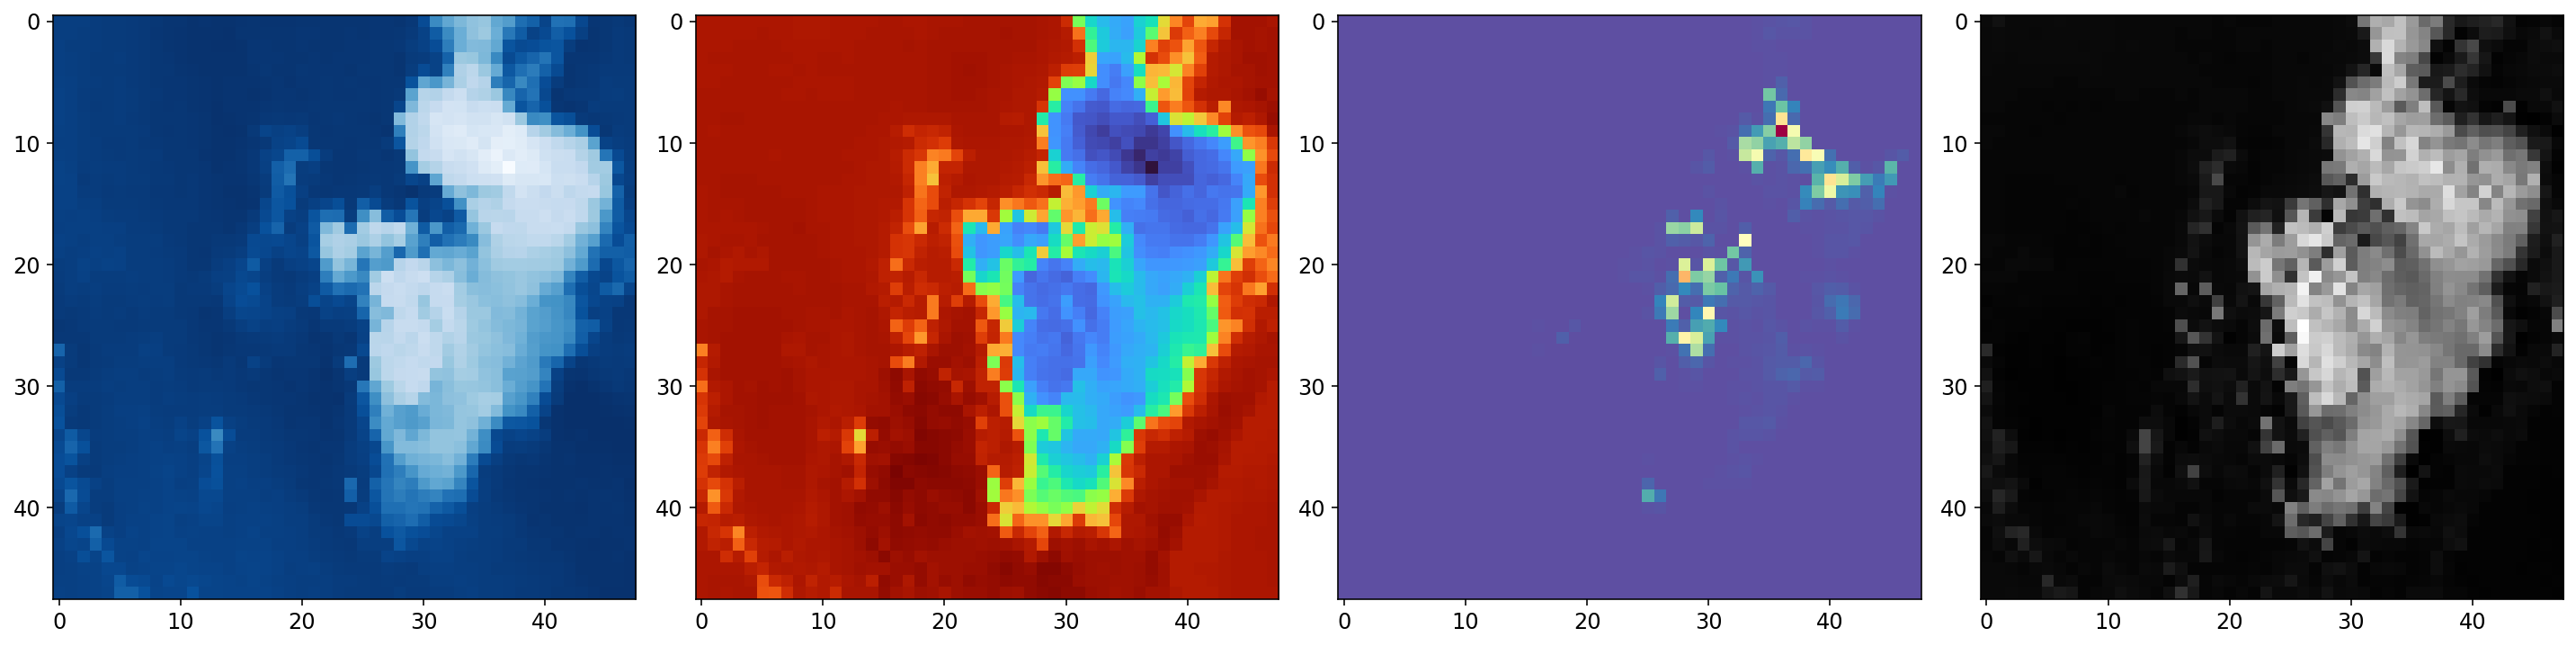

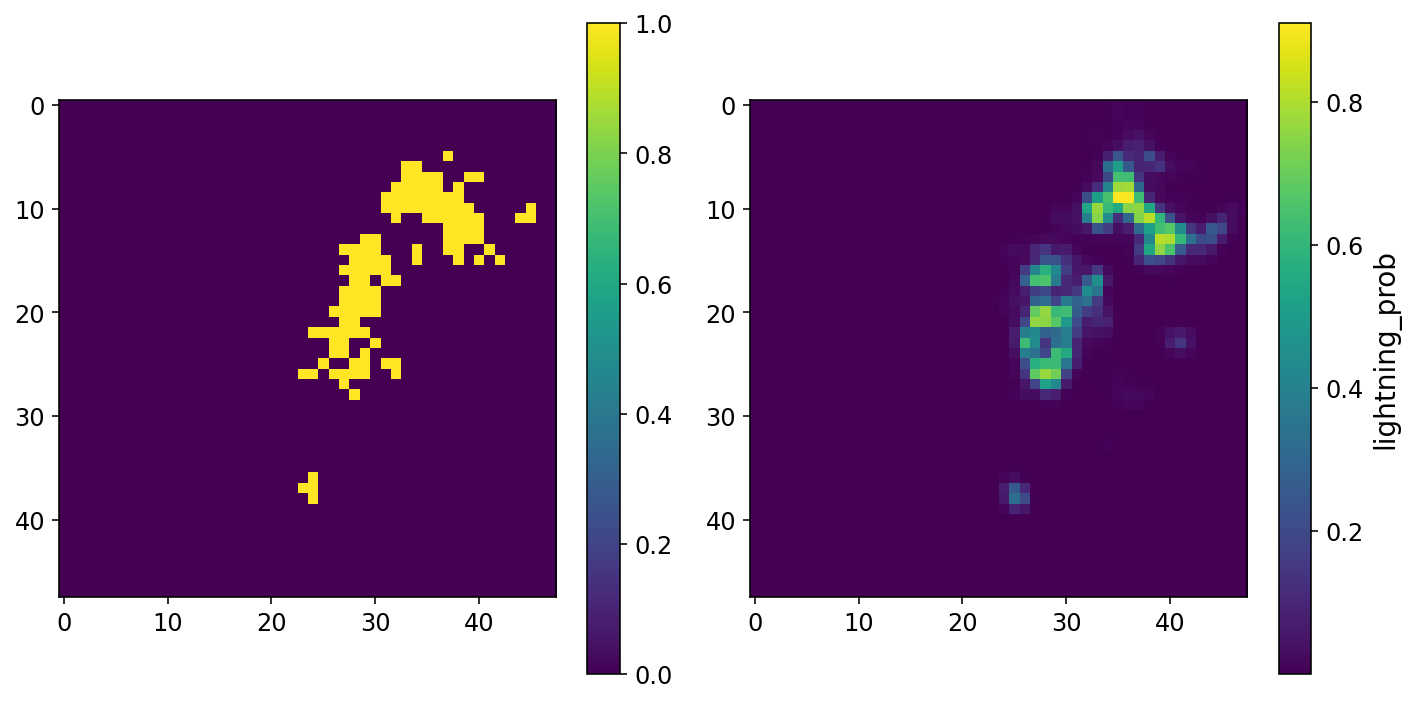

In [26]:
#get the features for example 12 in this batch 
one_example_features = batch[0][27]
#get the label for that same example 
one_example_label = batch[1][27]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

plt.tight_layout()


fig,axes = plt.subplots(1,2,figsize=(10,5),facecolor='w')
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm,ax=axes[0])
pm = axes[1].imshow(y_preds[27])
plt.colorbar(pm,ax=axes[1],label='lightning_prob')


plt.tight_layout()

In [27]:
import copy 
for i,(_,y) in enumerate(ds_val):
    if i == 0:
        y_v = copy.deepcopy(y)
    else:
        y_v = np.concatenate([y_v,y])

#ravel both
y_v_rav = y_v.ravel()
y_preds_rav = y_preds.ravel()

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


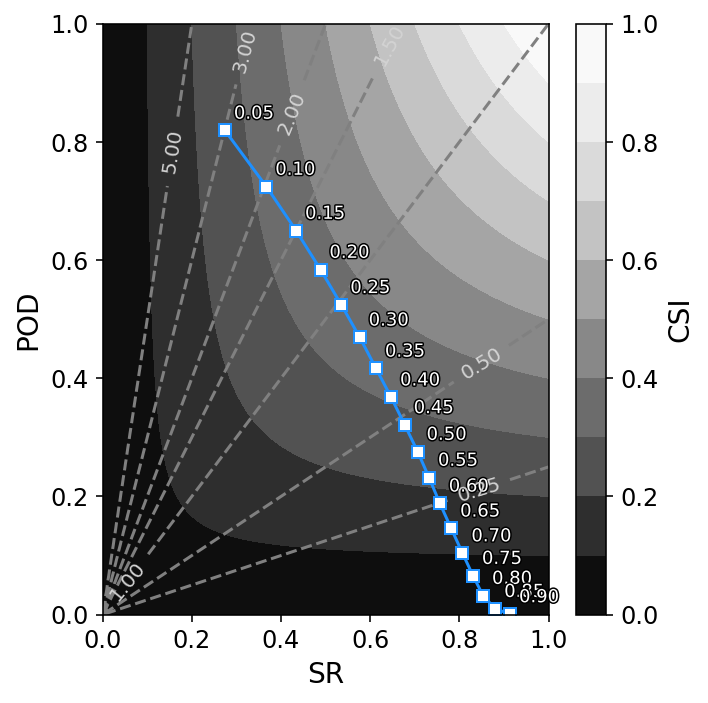

In [28]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

There ya go. There is plenty of room for improvement here, so feel free to play around with the model parameters!

The next notebook will dive into methods that can be used to help explain the performance of CNNs. 